#### Imports

In [1]:
!pip install keras[tensorflow]

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
from PIL import Image
import glob
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras import Model

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
# from scikeras.wrappers import KerasClassifier

#### Import the Data

In [3]:
!unzip -q /content/hotdog-nothotdog.zip

unzip:  cannot find or open /content/hotdog-nothotdog.zip, /content/hotdog-nothotdog.zip.zip or /content/hotdog-nothotdog.zip.ZIP.


In [4]:
# Image generator step comes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#### Transfer Learning

In [27]:
data_folder_train = '/kaggle/input/hotdognothotdog/hotdog-nothotdog/train'
data_folder_test = '/kaggle/input/hotdognothotdog/hotdog-nothotdog/test'
pretrained_size = (128,128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder_train,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_folder_test,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 2100 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
class names:  ['hotdog', 'nothotdog']


In [22]:
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False,
                                                input_shape = (128, 128, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [29]:
# Freeze the already-trained layers in the base model
for layer in base_model.layers:
  layer.trainable = False

# Create prediction layer for classification of our images
x = base_model.output
x = Flatten()(x)

prediction_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [30]:
num_epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/10
70/70 [==============================] - 48s 628ms/step - loss: 0.7147 - accuracy: 0.5257 - val_loss: 0.6831 - val_accuracy: 0.5444
Epoch 2/10
70/70 [==============================] - 44s 627ms/step - loss: 0.6747 - accuracy: 0.5700 - val_loss: 0.6792 - val_accuracy: 0.5333
Epoch 3/10
70/70 [==============================] - 44s 632ms/step - loss: 0.6524 - accuracy: 0.6229 - val_loss: 0.6810 - val_accuracy: 0.5667
Epoch 4/10
70/70 [==============================] - 43s 619ms/step - loss: 0.6718 - accuracy: 0.5824 - val_loss: 0.7637 - val_accuracy: 0.5111
Epoch 5/10
70/70 [==============================] - 42s 606ms/step - loss: 0.6421 - accuracy: 0.6195 - val_loss: 0.6772 - val_accuracy: 0.5667
Epoch 6/10
70/70 [==============================] - 43s 620ms/step - loss: 0.6424 - accuracy: 0.6190 - val_loss: 0.6527 - val_accuracy: 0.6444
Epoch 7/10
70/70 [==============================] - 43s 616ms/step - loss: 0.6348 - accuracy: 0.6357 - val_loss: 0.6504 - val_accuracy: 0.6056

In [5]:
files=glob.glob("/kaggle/input/hotdognothotdog/hotdog-nothotdog/train/hotdog/*.jpg")
TrainData = []
index = 0

for file in files:
    img = Image.open(file)
    img = img.resize((128, 128))
    imgarray = np.asarray(img)
    TrainData.append((imgarray,1))

files=glob.glob("/kaggle/input/hotdognothotdog/hotdog-nothotdog/train/nothotdog/*.jpg")
index = 0
for file in files:
    img = Image.open(file)
    img = img.resize((128, 128))
    imgarray = np.asarray(img)
    TrainData.append((imgarray,0))

print("Done.")

random.shuffle(TrainData)

Done.


In [6]:
files=glob.glob("/kaggle/input/hotdognothotdog/hotdog-nothotdog/test/hotdog/*.jpg")
TestData = []
index = 0

for file in files:
    img = Image.open(file)
    img = img.resize((128, 128))
    imgarray = np.asarray(img)
    TestData.append((imgarray,1))

files=glob.glob("/kaggle/input/hotdognothotdog/hotdog-nothotdog/test/nothotdog/*.jpg")
index = 0
for file in files:
    img = Image.open(file)
    img = img.resize((128, 128))
    imgarray = np.asarray(img)
    TestData.append((imgarray,0))

print("Done.")

random.shuffle(TestData)

Done.


#### Check Dimensions of the Data

In [7]:
print("TrainData ",len(TrainData))
print("TestData ",len(TestData))

TrainData  3000
TestData  644


#### Modeling

Train-Test-Split


In [8]:
X_train = np.array([item[0] for item in TrainData])
y_train = np.array([item[1] for item in TrainData])

X_test = np.array([item[0] for item in TestData])
y_test = np.array([item[1] for item in TestData])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

#### Convolutional Neural Network

In [31]:
model = keras.Sequential([
    keras.layers.AveragePooling2D((2,2),2,input_shape=(128,128,3)),
    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
#     keras.layers.Conv2D(32,(3,3),activation='relu'),
#     keras.layers.Conv2D(64,(3,3),activation='relu'),
#     keras.layers.MaxPool2D(),
#     keras.layers.Dropout(0.3),
#     keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
#     keras.layers.MaxPool2D(),
#     keras.layers.Dropout(0.2),
#     keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(
  monitor='val_loss',
  patience=5,
  verbose=1,
  restore_best_weights=True
)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
epochs = 25, batch_size = 40,
                    callbacks=[early_stop]
)

Epoch 1/25
75/75 [==============================] - 22s 286ms/step - loss: 0.7097 - accuracy: 0.5560 - val_loss: 0.6773 - val_accuracy: 0.5994
Epoch 2/25
75/75 [==============================] - 22s 291ms/step - loss: 0.6483 - accuracy: 0.6307 - val_loss: 0.6470 - val_accuracy: 0.5901
Epoch 3/25
75/75 [==============================] - 21s 286ms/step - loss: 0.6151 - accuracy: 0.6573 - val_loss: 0.6440 - val_accuracy: 0.6196
Epoch 4/25
75/75 [==============================] - 21s 277ms/step - loss: 0.6104 - accuracy: 0.6723 - val_loss: 0.6354 - val_accuracy: 0.6211
Epoch 5/25
75/75 [==============================] - 21s 287ms/step - loss: 0.5907 - accuracy: 0.6910 - val_loss: 0.6273 - val_accuracy: 0.6460
Epoch 6/25
75/75 [==============================] - 21s 283ms/step - loss: 0.5882 - accuracy: 0.6963 - val_loss: 0.6207 - val_accuracy: 0.6444
Epoch 7/25
75/75 [==============================] - 21s 275ms/step - loss: 0.5719 - accuracy: 0.7020 - val_loss: 0.6209 - val_accuracy: 0.6724

In [32]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


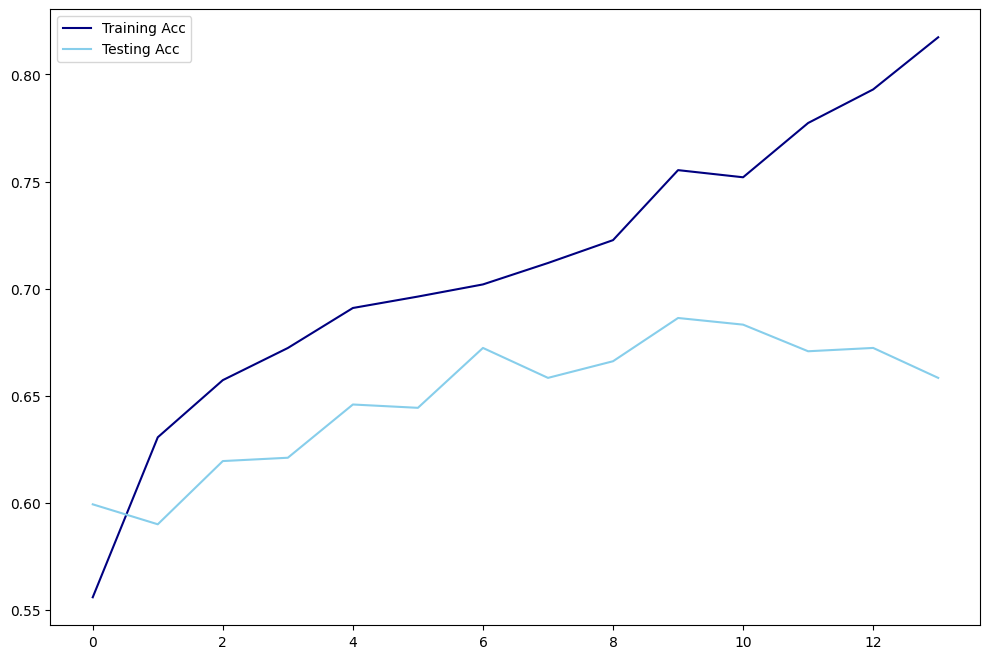

In [33]:
# Visualize the Acc
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Acc', color='navy')
plt.plot(test_acc, label='Testing Acc', color='skyblue')
plt.legend();

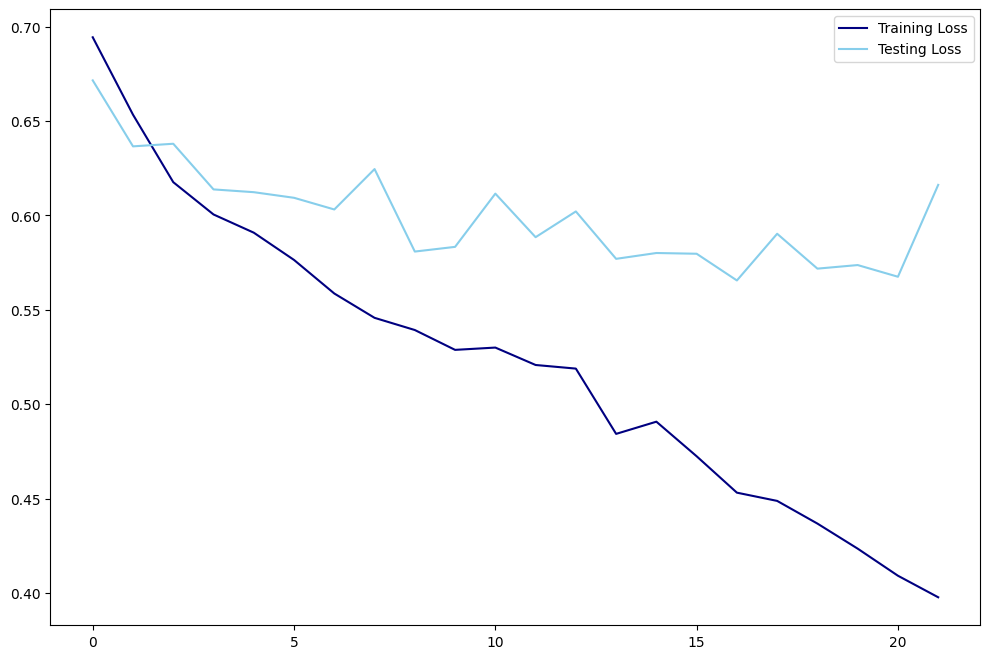

In [18]:
# Visualize the Loss
train_acc = history.history['loss']
test_acc = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Loss', color='navy')
plt.plot(test_acc, label='Testing Loss', color='skyblue')
plt.legend();

In [36]:
model.save('model.h5')
model.save('model.keras')